<h1 align="center">Dự đoán khả năng nợ quá hạn đối với từng khách hàng</h1>

**Mục tiêu tổng quát:**

Thực hiện dự án machine learning để xem xét khả năng dự đoán tình hình nợ quá hạn của các thuật toán học máy trên bộ dữ liệu được cung cấp

**Mục tiêu cụ thể:**
- Tìm hiểu về bộ dữ liệu và thực hiện dọn sạch dữ liệu (nếu cần thiết)
- Xây dựng các mô hình dự đoán về tình hình nợ quá hạn đối với từng khách hàng
- Thực hiện điều chỉnh các siêu tham số phù hợp nhất và so sánh các mô hình học máy bằng các chỉ số khác nhau 
- Lưu lại mô hình để có thể tái sử dụng trong tương lai


<h1 align= "center">Nội dung phân tích</h1>

**Để có thể thực hiện dự án, cần phải thực hiện một số bước sau:**

1. Import các bộ thư viện cần thiết
2. Tìm hiểu sơ bộ dữ liệu
3. Phân tích dữ liệu khám phá (EDA)
4. Tiền xử lý dữ liệu
5. Xây dựng pipeline cho các thuật toán
6. So sánh các mô hình
7. So sánh hiệu suất các mô hình
8. Kết luận

<h1 align= "center">Thực hiện phân tích</h1>

# 1. Import libraries 

In [1]:
# Phân tích, thao tác, trực quan dữ liệu
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

# Xây dựng pipeline
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Feature transformation
from sklearn.preprocessing import StandardScaler,OneHotEncoder

# Bộ thuật toán xây dựng mô hình
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_validate, KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve, confusion_matrix

# Bộ thư viện liên quan khác
import warnings
warnings.filterwarnings(action='ignore')

# 2. Tìm hiểu sơ bộ dữ liệu:

In [2]:
# Import the dataset
original_df = pd.read_csv("sample_accounting_transactions.csv")
original_df.head()

,Customer Name,Year of Birth,Customer Gender,Customer Email,Customer City,Sales Employee,Sales Channel,Ad Media,Product ID,Order Date,Delivery Date,Invoice Date,Sales Amount,Cash Collected,Outstanding Amount,Overdue
0,Paige Ford,1999.0,Male,sanchezjoshua@example.org,C02,E05,Online,Social Media,P05,12/1/2019,12/29/2019,12/1/2019,15099.71,1189.61,11002.63,Yes
1,Kelli Shelton,1981.0,Female,dmckinney@example.net,C02,E06,Online,KOL,P04,11/6/2023,11/18/2023,11/6/2023,23130.47,2218.21,20914.36,No
2,Melanie Lamb,1998.0,Male,grobbins@example.org,C02,E05,In-store,Social Media,P01,1/17/2023,2/3/2023,1/17/2023,23297.38,5985.45,10460.48,No
3,Monica Mccullough,1985.0,Male,ejacobs@example.org,C02,E03,Distributors,KOL,P01,9/28/2019,10/6/2019,9/28/2019,21772.60,1271.61,9165.50,Yes
4,Angela Thomas,2004.0,Female,joshua27@example.com,C01,E01,In-store,Email,P02,8/28/2023,9/20/2023,8/28/2023,26500.92,133.12,13992.94,No


Theo đánh giá chủ quan, một số dữ liệu mang tính chất tương tự nhau và không cần thiết nên cần có quyết định loại bỏ đi 

In [3]:
# Chọn các features cần loại bỏ
drop_features = ['Customer Name','Customer Email', 'Delivery Date', 'Invoice Date', 'Cash Collected', 'Outstanding Amount']
df = original_df.drop(columns=drop_features).copy()

# Xem 5 dòng đầu tiên về bộ dữ liệu
df.head()

,Year of Birth,Customer Gender,Customer City,Sales Employee,Sales Channel,Ad Media,Product ID,Order Date,Sales Amount,Overdue
0,1999.0,Male,C02,E05,Online,Social Media,P05,12/1/2019,15099.71,Yes
1,1981.0,Female,C02,E06,Online,KOL,P04,11/6/2023,23130.47,No
2,1998.0,Male,C02,E05,In-store,Social Media,P01,1/17/2023,23297.38,No
3,1985.0,Male,C02,E03,Distributors,KOL,P01,9/28/2019,21772.60,Yes
4,2004.0,Female,C01,E01,In-store,Email,P02,8/28/2023,26500.92,No


Xác định mục tiêu cần phải phân loại cùng với các đặc trưng đầu vào

In [4]:
# Chọn ra biến target 
target = 'Overdue'
# Phân loại các biến predictors trong bộ dữ liệu ban đầu
nf = ['Year of Birth','Sales Amount']
cf = ['Customer Gender','Customer City','Sales Employee','Sales Channel','Ad Media','Product ID']

In [5]:
# Xem kiểu dữ liệu của tập dữ liệu
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Year of Birth    999 non-null    float64
 1   Customer Gender  998 non-null    object 
 2   Customer City    996 non-null    object 
 3   Sales Employee   997 non-null    object 
 4   Sales Channel    995 non-null    object 
 5   Ad Media         996 non-null    object 
 6   Product ID       999 non-null    object 
 7   Order Date       993 non-null    object 
 8   Sales Amount     1000 non-null   float64
 9   Overdue          1000 non-null   object 
dtypes: float64(2), object(8)
memory usage: 78.2+ KB


In [6]:
# Kiểm tra các số lượng dữ liệu duy nhất của từng cột
df.nunique().sort_values()

Customer Gender       2
Overdue               2
Customer City         3
Sales Channel         3
Ad Media              4
Product ID            5
Sales Employee        8
Year of Birth        41
Order Date          793
Sales Amount       1000
dtype: int64

In [7]:
# Thống kê của các cột dữ liệu
df.describe(include="all")

,Year of Birth,Customer Gender,Customer City,Sales Employee,Sales Channel,Ad Media,Product ID,Order Date,Sales Amount,Overdue
count,999.000000,998,996,997,995,996,999,993,1000.000000,1000
unique,NaN,2,3,8,3,4,5,793,NaN,2
top,NaN,Male,C01,E01,Online,KOL,P01,6/8/2023,NaN,No
freq,NaN,645,469,204,454,372,309,4,NaN,709
mean,1990.003003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24573.798330,NaN
std,11.762215,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5297.711214,NaN
min,1965.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12687.720000,NaN
25%,1981.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20514.822500,NaN
50%,1992.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24049.115000,NaN
75%,2001.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28240.647500,NaN


# 3. Phân tích dữ liệu khám phá (EDA):

#### Phân tích đơn biến

In [8]:
# Hàm phân tích dữ liệu định tính
def num_analyze(data):
    fig, ax = plt.subplots(1,2, figsize = (12,5))
    sns.despine()
    
    # Histogram
    sns.distplot(data, ax = ax[0])
    ax[0].set_title(f"Histogram of {data.name}")
    
    # Boxplot
    sns.boxplot(x=data, ax = ax[1])
    ax[1].set_title(f"Boxplot of {data.name}")

# Hàm phân tích dữ liệu định lượng
def cat_analyze(data):
    fig, ax = plt.subplots(1,2, figsize = (12,5))
    sns.despine()
    _input = data.value_counts().sort_values()
    #Barplot
    sns.barplot(x = _input.index,
                y = _input,ax=ax[0])
    ax[0].set_title(f"Barplot of {data.name}")

    #Piechart
    ax[1].pie(x = _input,
            labels = _input.index, 
            startangle=90,
            autopct='%.1f%%',
            pctdistance = 0.83)
    ax[1].pie(x=[data.shape[0]],colors=['powderblue'],radius=0.7,autopct='%.0f%%',pctdistance=0)
    ax[1].set_title(f"Pie chart of {data.name}")    

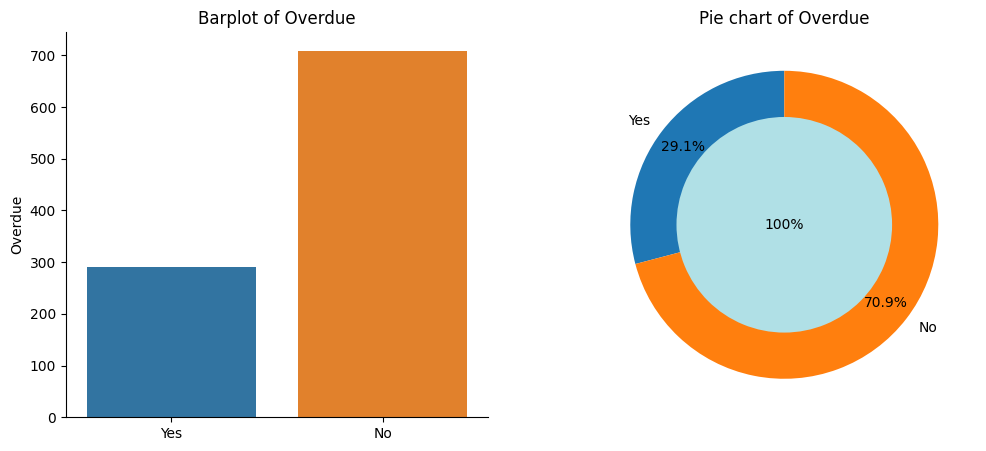

In [9]:
# Phân tích phân phối của biến mục tiêu
cat_analyze(df[target])

Có sự chênh lệch đáng kể giữa 2 lớp dữ liệu bên trong cột dữ liệu mục tiêu Overdue

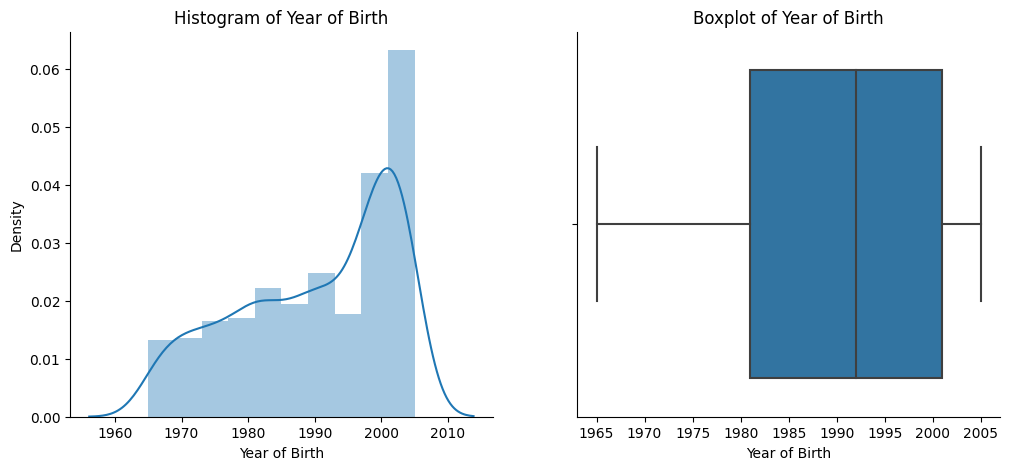

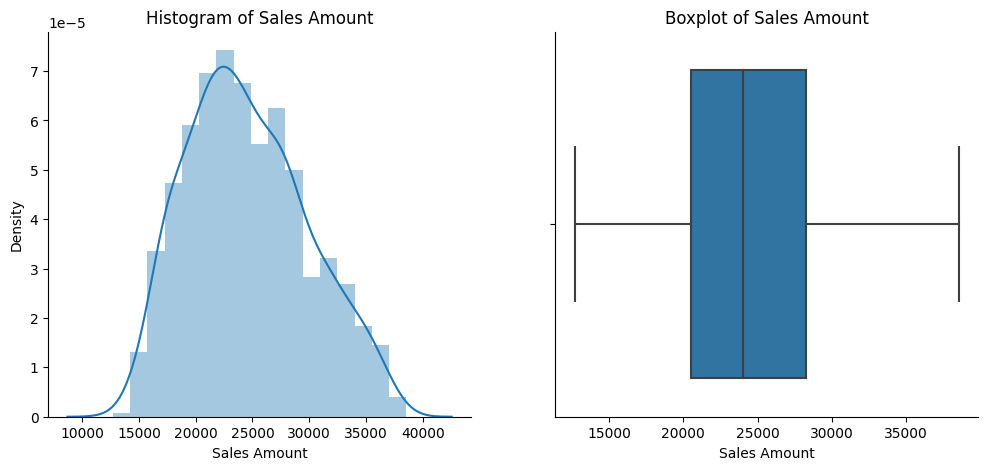

In [10]:
# Phân tích các biến định lượng
for col in nf:
    num_analyze(df[col])

Phân phối của năm sinh cho thấy rằng phần lớn mẫu khảo sát được lấy từ người trẻ tuổi, phân phối của doanh thu bị lệch trái, đa số ở mức 15000

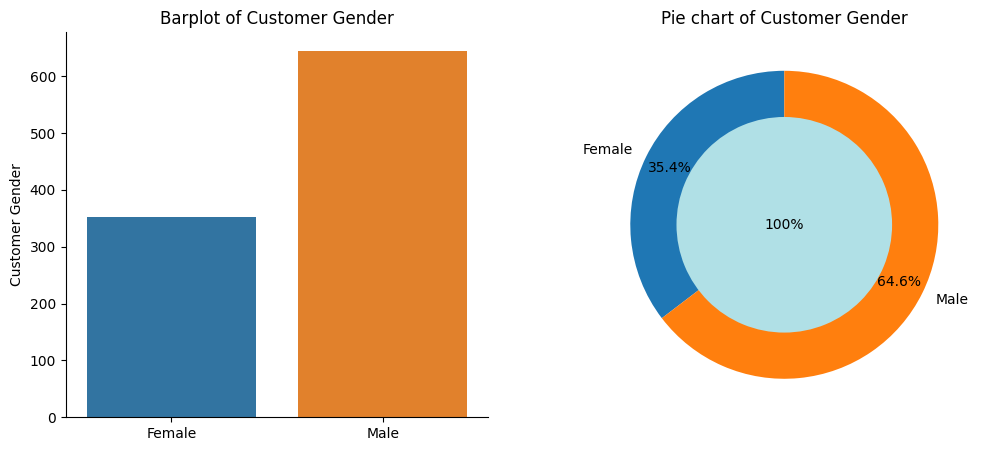

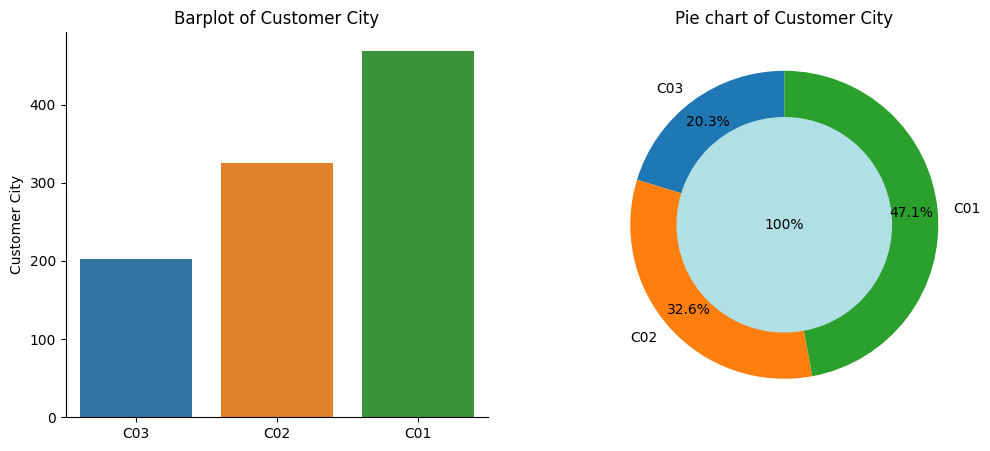

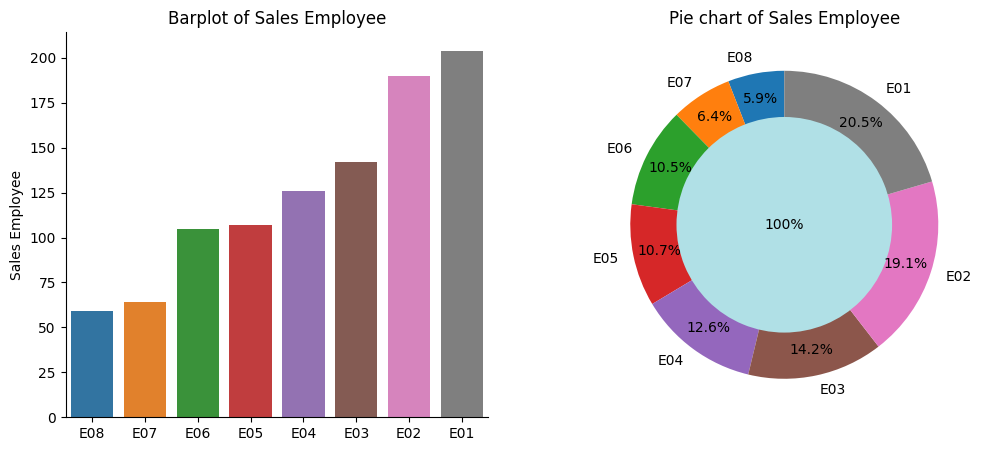

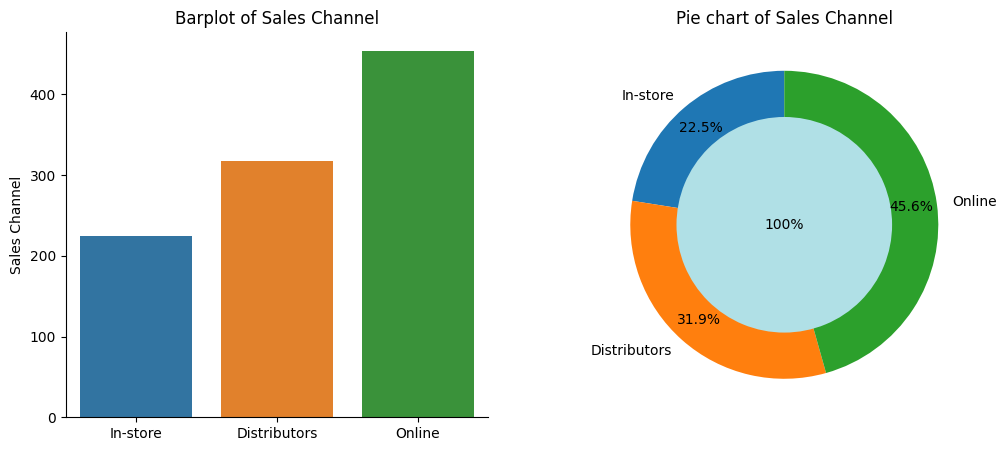

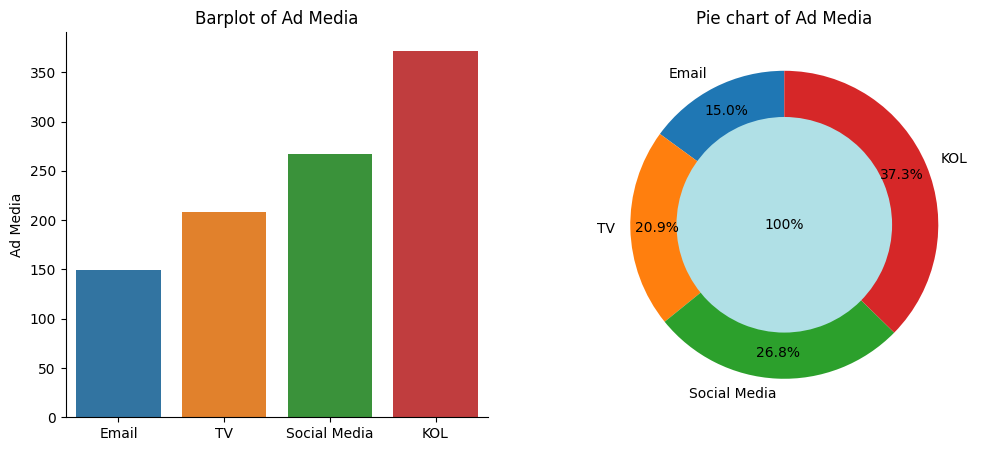

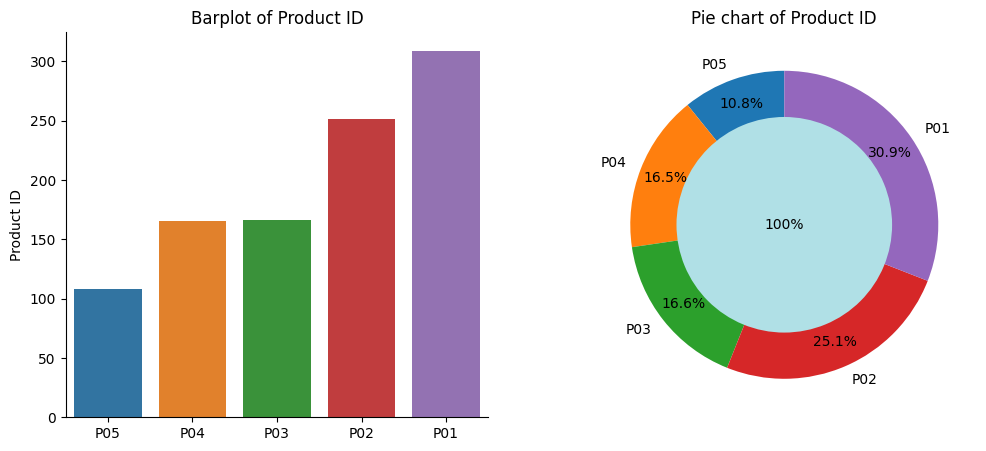

In [11]:
# Phân tích các biến phân loại/ định tính
for col in cf:
    cat_analyze(df[col])

#### Phân tích đa biến

In [12]:
# Hàm phân tích đa biến
def multi_analyze_cate(data, col):
    plt.figure(figsize=(10,5))
    sns.countplot(data = data, x = col, hue=target)
    plt.title(f'Quantity of {col} categorized by {target}')
    sns.despine()  

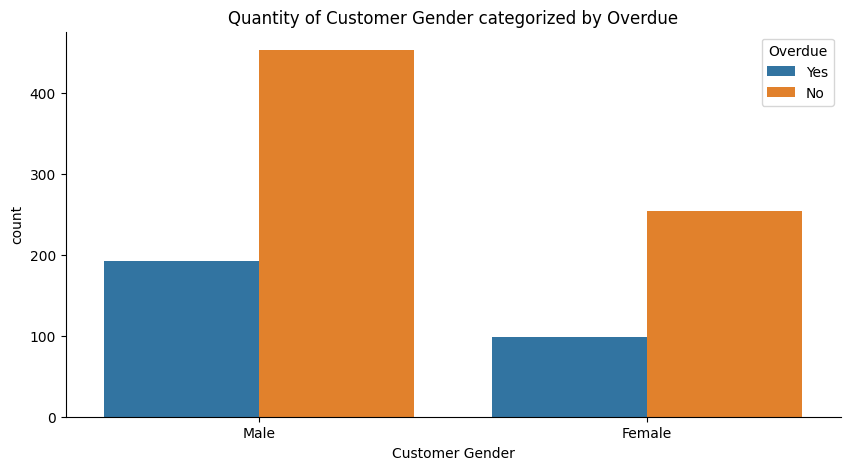

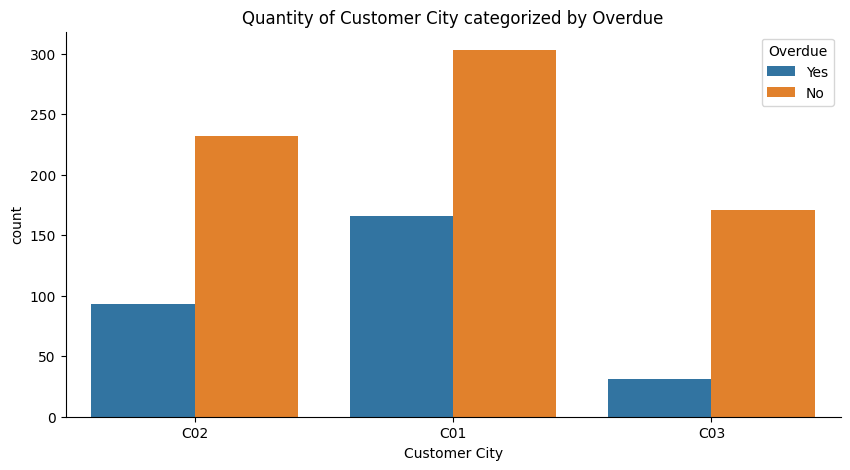

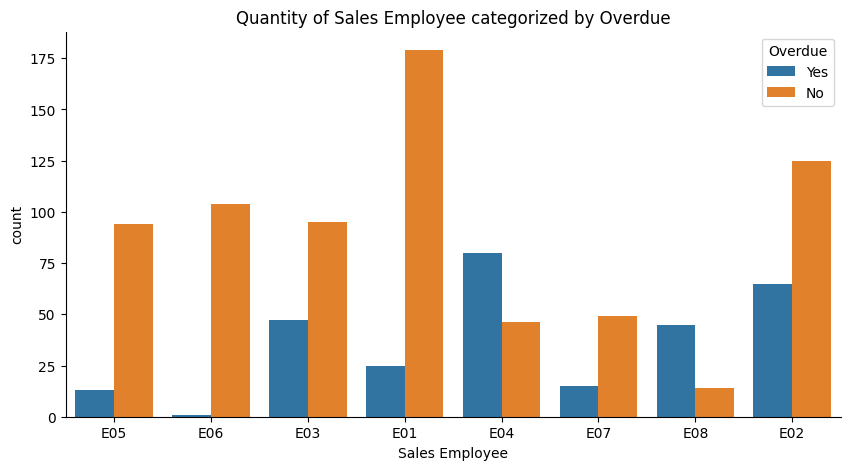

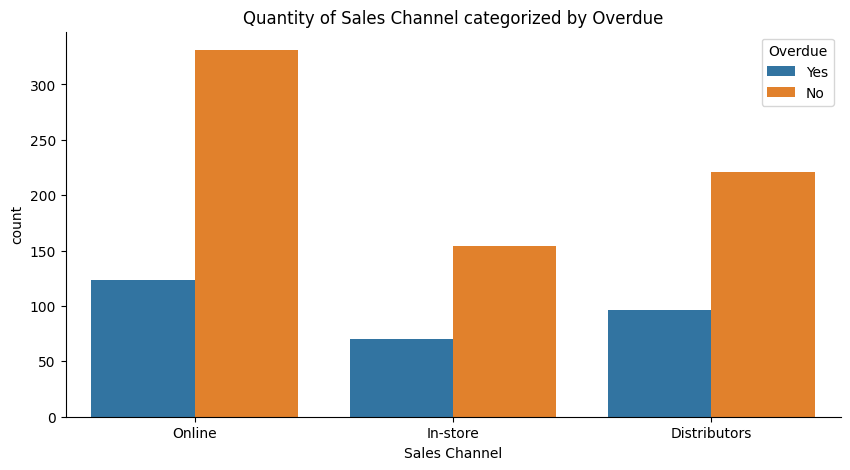

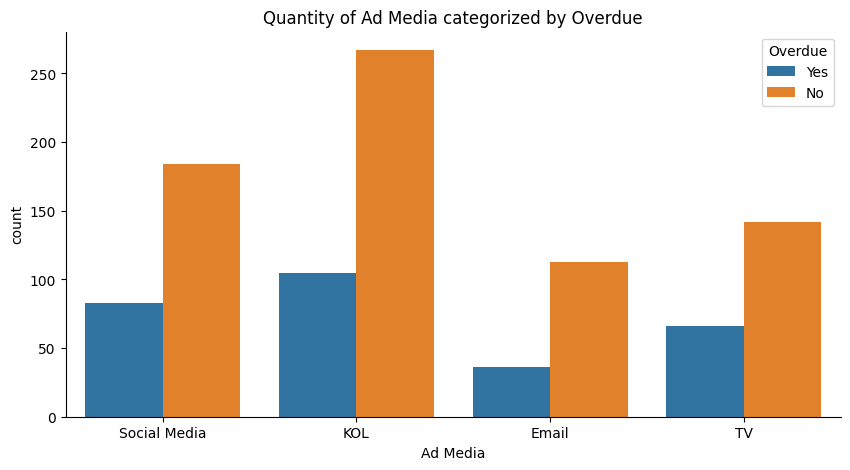

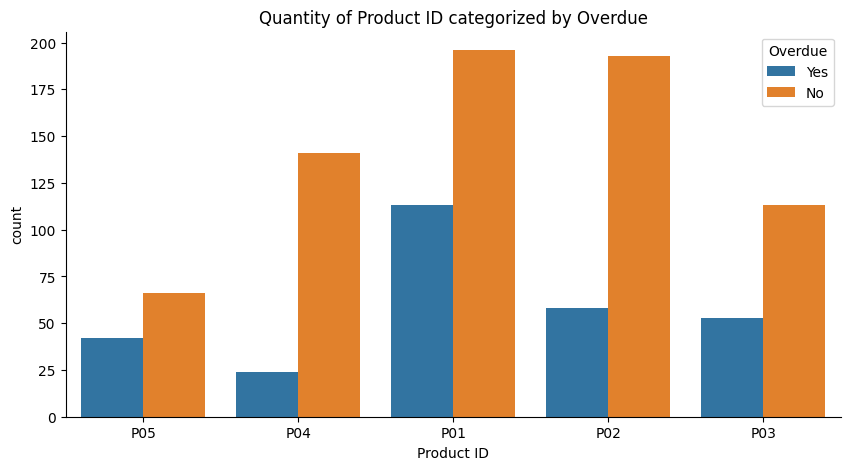

In [13]:
for col in cf:
    multi_analyze_cate(data = df, col=col)

Có sự khác biệt dễ dàng nhìn thấy được giữa các tổng thể

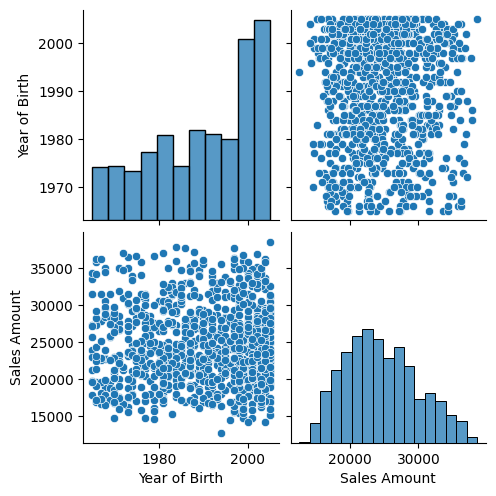

In [14]:
sns.pairplot(df)

Text(0.5, 1.0, 'Pearson Correlation')

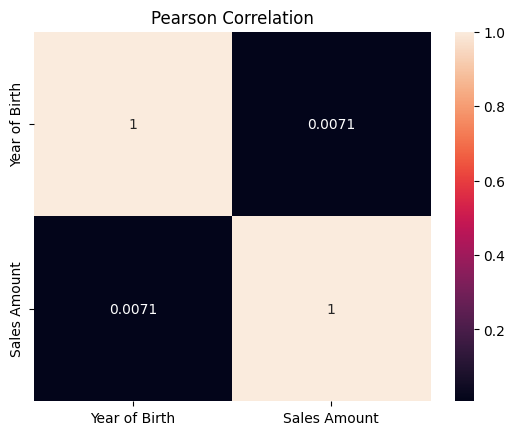

In [15]:
sns.heatmap(df.corr(),annot=True)
plt.title('Pearson Correlation')

Một số điểm trong biểu đồ phân tán cho thấy rằng đối với các khách hàng càng lớn tuổi thì sẽ có khả năng đem lại doanh thu ít hơn, tuy nhiên mối quan hệ này không đáng kể

# 4. Tiền xử lý dữ liệu

Trước khi xây dựng mô hình, cần phải thực hiện các bước làm sạch dữ liệu, để quá trình xây dựng tránh gặp trục trặc về dữ liệu

In [16]:
# Loại bỏ các dòng dữ liệu bị trùng lặp (nếu có)
df.duplicated().sum()
# df.drop_duplicates(inplace=True)

0

In [17]:
# Xem tỉ lệ dữ liệu bị thiếu (nếu có)
nvc = pd.DataFrame(df.isnull().sum().sort_values(), 
                   columns=['Số lượng dữ liệu thiếu'])
nvc['Tỉ lệ dữ liệu thiếu'] = round(nvc['Số lượng dữ liệu thiếu']/df.shape[0],3)*100
nvc

,Số lượng dữ liệu thiếu,Tỉ lệ dữ liệu thiếu
Sales Amount,0,0.0
Overdue,0,0.0
Year of Birth,1,0.1
Product ID,1,0.1
Customer Gender,2,0.2
Sales Employee,3,0.3
Customer City,4,0.4
Ad Media,4,0.4
Sales Channel,5,0.5
Order Date,7,0.7


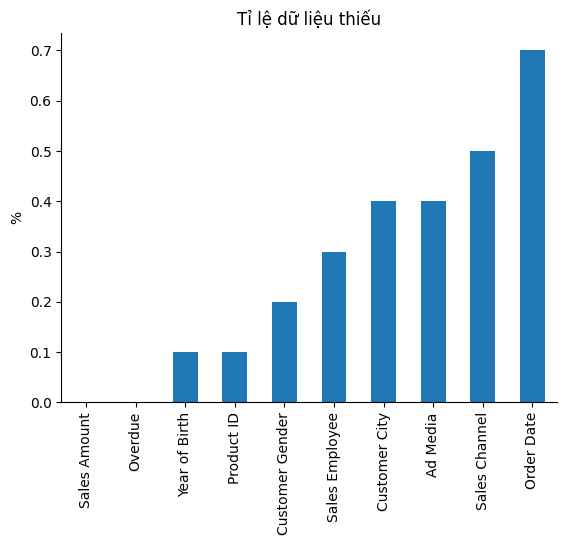

In [18]:
(df.isnull().mean()*100).sort_values().plot(kind='bar', title = 'Tỉ lệ dữ liệu thiếu')
plt.ylabel('%')
sns.despine()

<AxesSubplot: >

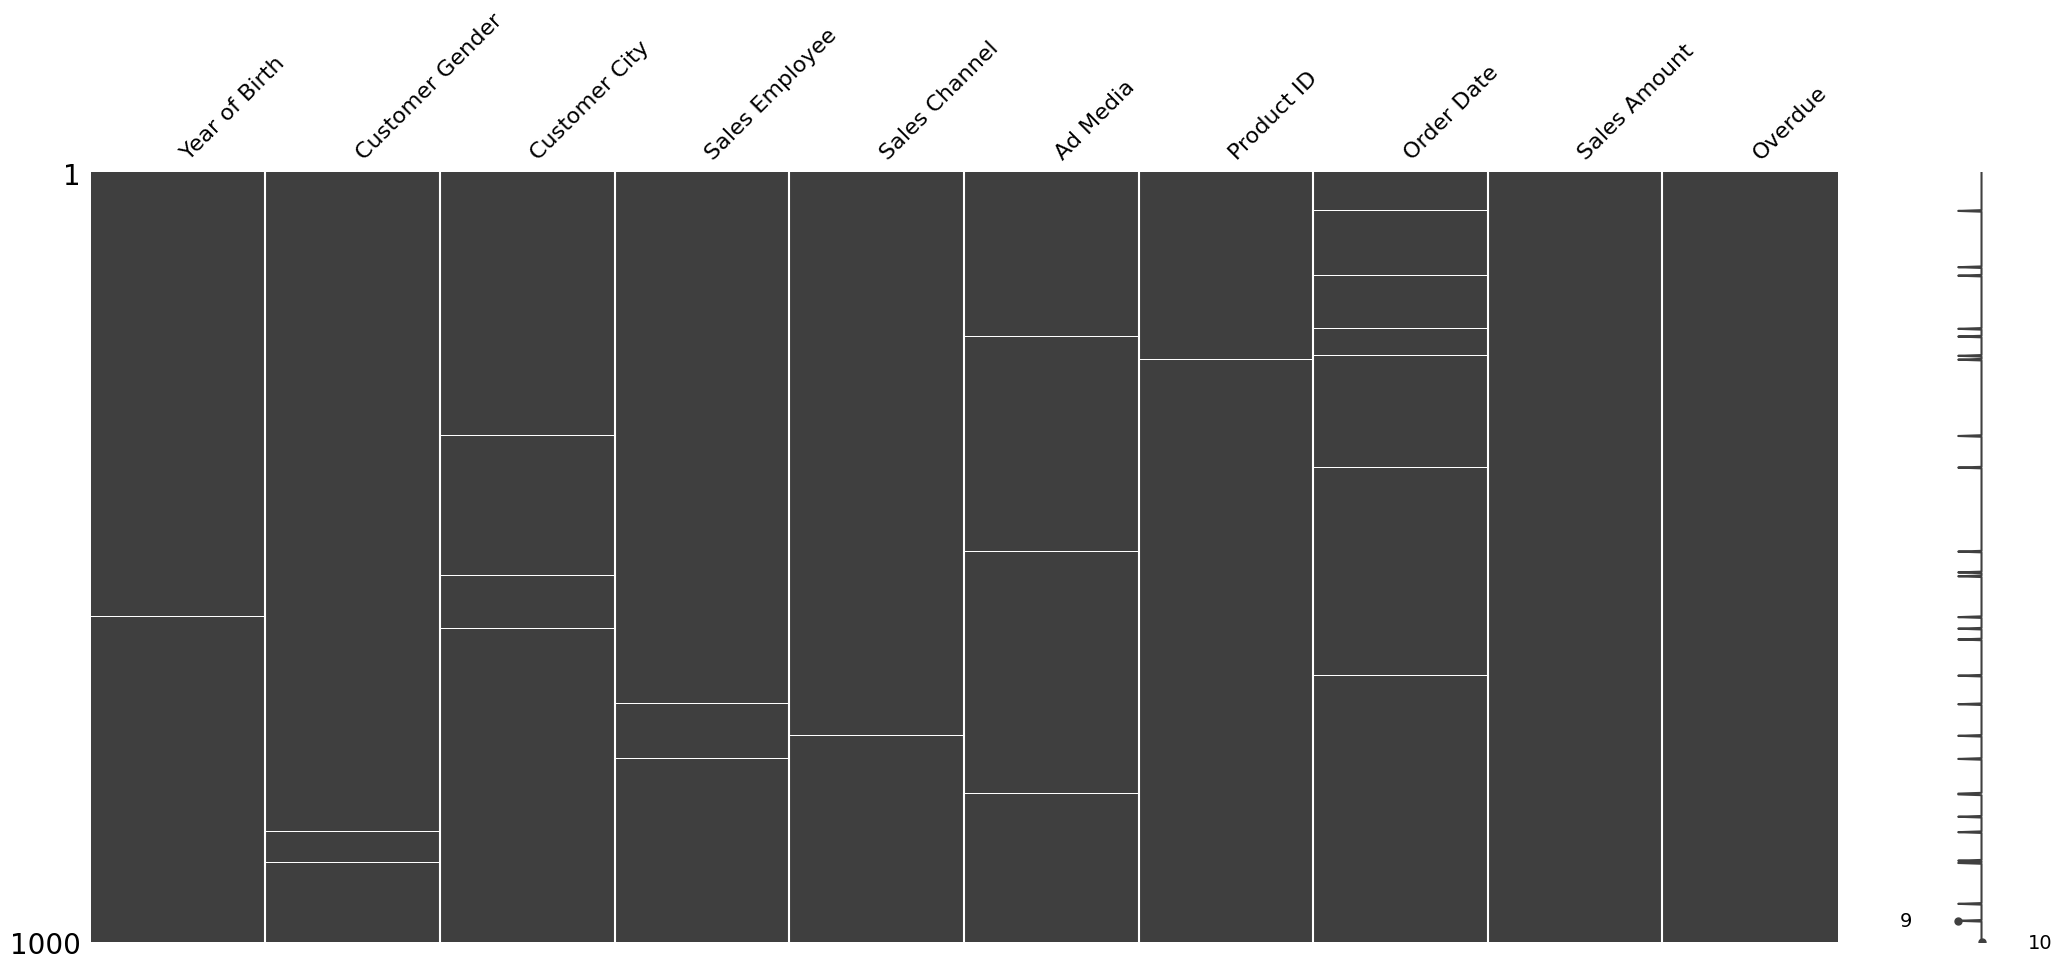

In [19]:
msno.matrix(df)

Text(0.5, 1.0, 'Tỷ lệ tổng dữ liệu bị thiếu')

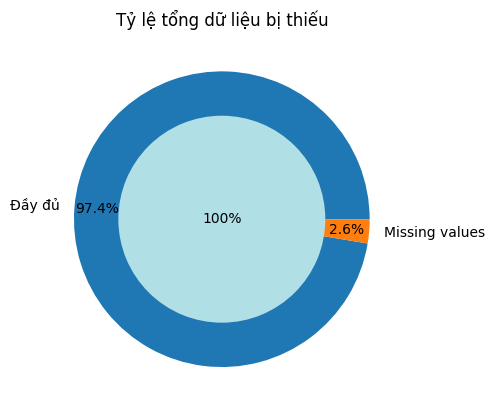

In [20]:
# Tỉ lệ dữ liệu thiếu trên toàn bộ tập dữ liệu
mc = df.isnull().any(axis=1).sum()
plt.pie(x = [df.shape[0],mc], 
        labels = ['Đầy đủ','Missing values'],
        autopct = '%.1f%%',
        pctdistance=0.85)
plt.pie(x=[df.shape[0]],colors=['powderblue'],radius=0.7,autopct='%.0f%%',pctdistance=0)
plt.title('Tỷ lệ tổng dữ liệu bị thiếu')

Bởi vì tỉ lệ dữ liệu thiếu không nhiều, nên biện pháp tốt nhất sẽ là loại bỏ các dữ liệu bị thiếu trong tập dữ liệu

In [21]:
# Xóa các quan sát chứa dữ liệu bị thiếu trên tập dữ liệu
df.dropna(axis=0,inplace=True)
df.shape

(973, 10)

Còn lại tổng cộng 966 quan sát sau khi loại bỏ các dữ liệu bị thiếu

Tiếp tục, thực hiện rời rạc hóa cột dữ liệu "Year of Birth"

In [22]:
# Rời rạc hóa dữ liệu
df['Gen'] = pd.cut(df['Year of Birth'],bins = [0,1980,1996,9999],labels = ['X', 'Y', 'Z'])
df['Gen'] = df['Gen'].astype('str')
df = df.drop(columns = ['Year of Birth']).copy()
df.head()

,Customer Gender,Customer City,Sales Employee,Sales Channel,Ad Media,Product ID,Order Date,Sales Amount,Overdue,Gen
0,Male,C02,E05,Online,Social Media,P05,12/1/2019,15099.71,Yes,Z
1,Female,C02,E06,Online,KOL,P04,11/6/2023,23130.47,No,Y
2,Male,C02,E05,In-store,Social Media,P01,1/17/2023,23297.38,No,Z
3,Male,C02,E03,Distributors,KOL,P01,9/28/2019,21772.60,Yes,Y
4,Female,C01,E01,In-store,Email,P02,8/28/2023,26500.92,No,Z


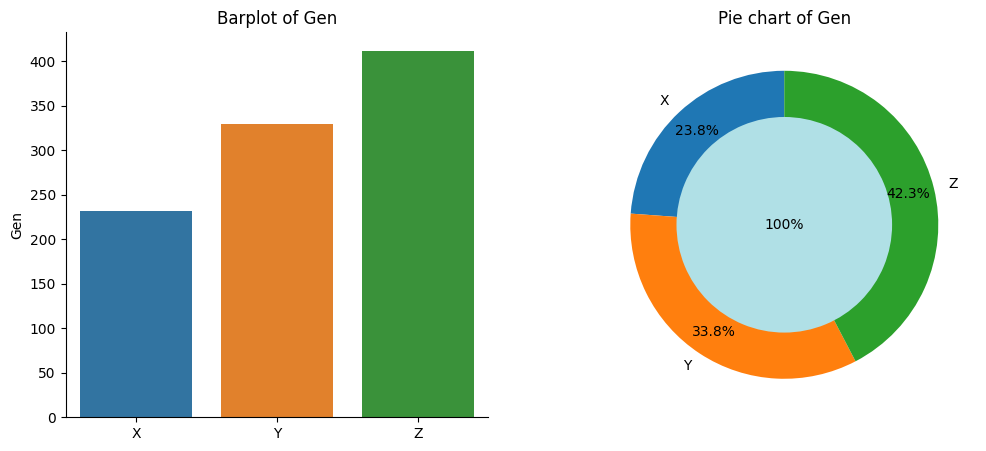

In [23]:
cat_analyze(df['Gen'])

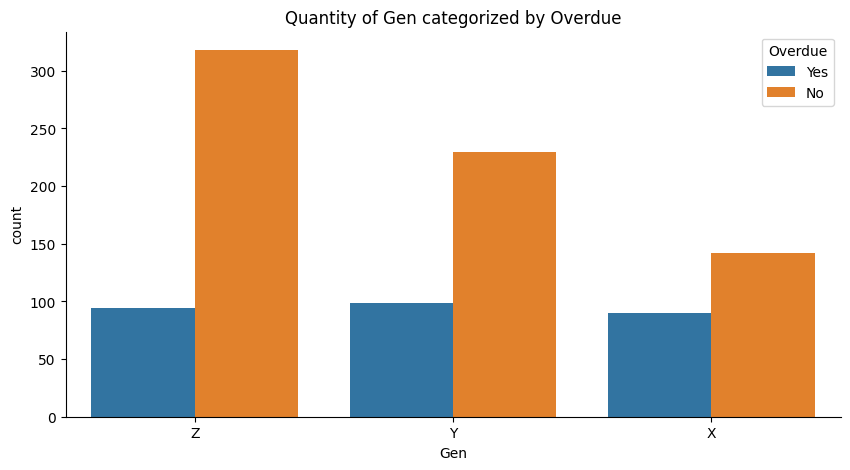

In [24]:
multi_analyze_cate(data = df, col = 'Gen')

In [25]:
# Lấy dữ liệu quý
df['Order Date'] = pd.to_datetime(df['Order Date'])
df['Quarter'] =  df['Order Date'].dt.quarter.astype('str')
df = df.drop(columns = ['Order Date']).copy()

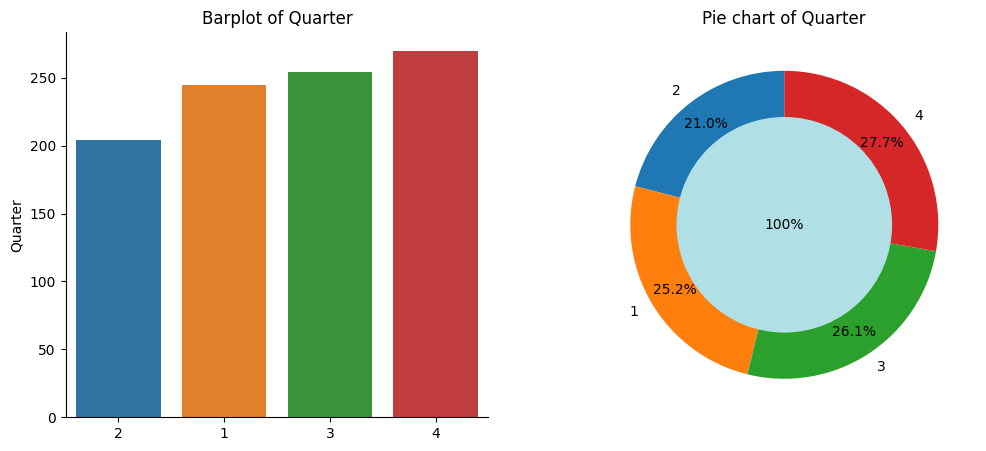

In [26]:
cat_analyze(df['Quarter'])

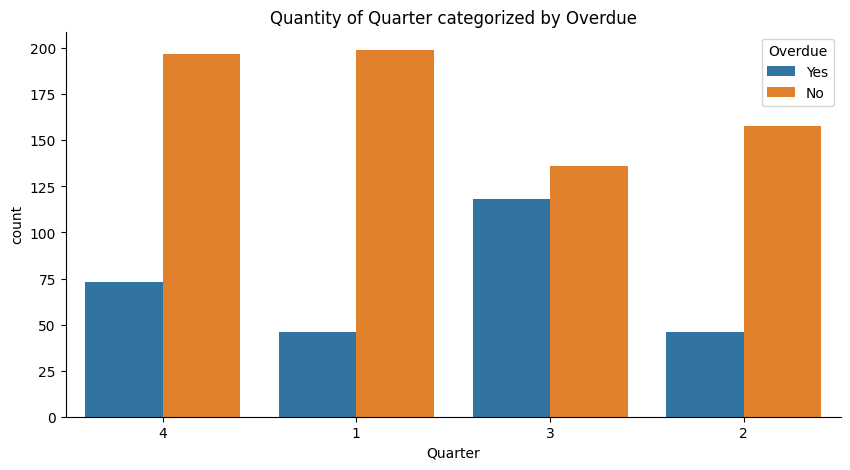

In [27]:
multi_analyze_cate(data = df, col = 'Quarter')

Ngoài ra để tránh rò rĩ dữ liệu (data leakage) và gọn nhẹ cho bài báo cáo, biện pháp tốt nhất chính là sử dụng data pipeline cho các bước như chuẩn hóa dữ liệu và mã hóa dữ liệu.

In [28]:
X = df.drop(columns=[target]).copy()
cat_list = X.select_dtypes(include='object').columns
num_list = X.select_dtypes(include='number').columns
y = df[target]

# Pipeline 
num_pl = Pipeline(steps=[
    ("Scaler",StandardScaler())
])

cat_pl = Pipeline(steps= [
    ("Encoder",OneHotEncoder(drop='first',sparse_output=False)) 
])

preprocessor = ColumnTransformer(transformers=[
    ("num_pre",num_pl, num_list),
    ("cat_pre",cat_pl, cat_list)
],remainder='passthrough')

Thực hiện ví dụ cho pipeline trong việc mã hóa dữ liệu và chuẩn hóa dữ liệu

In [29]:
encoded_data = preprocessor.fit_transform(X)
pd.DataFrame(encoded_data, columns=preprocessor.get_feature_names_out()).head()

,num_pre__Sales Amount,cat_pre__Customer Gender_Male,cat_pre__Customer City_C02,cat_pre__Customer City_C03,cat_pre__Sales Employee_E02,cat_pre__Sales Employee_E03,cat_pre__Sales Employee_E04,cat_pre__Sales Employee_E05,cat_pre__Sales Employee_E06,cat_pre__Sales Employee_E07,...,cat_pre__Ad Media_TV,cat_pre__Product ID_P02,cat_pre__Product ID_P03,cat_pre__Product ID_P04,cat_pre__Product ID_P05,cat_pre__Gen_Y,cat_pre__Gen_Z,cat_pre__Quarter_2,cat_pre__Quarter_3,cat_pre__Quarter_4
0,-1.797033,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
1,-0.277701,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
2,-0.246124,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,-0.534595,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,0.359951,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


# 5. Xây dựng pipeline xử lý thuật toán

In [30]:
# Fold
inner_fold = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)
outer_fold = StratifiedKFold(n_splits=3, shuffle=True, random_state=1)

In [31]:
# Logistic
lg_pl = Pipeline(steps = [
    ('preprocessor',preprocessor),
    ('estimator',LogisticRegression())
])

lg_grid = {'estimator__C': [0.01, 0.1, 1.0]}

lg_pl_grid = GridSearchCV(lg_pl, param_grid=lg_grid, scoring = 'roc_auc', cv = inner_fold, n_jobs=-1)
lg_pl_grid

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=0, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num_pre',
                                                                         Pipeline(steps=[('Scaler',
                                                                                          StandardScaler())]),
                                                                         Index(['Sales Amount'], dtype='object')),
                                                                        ('cat_pre',
                                                                         Pipeline(steps=[('Encoder',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        sparse_output=False))]),
                                                                         Index(['Customer Gender', 'Customer City', 'Sales Employee', 'Sales Channel',
       'Ad Media', 'Product ID', 'Gen', 'Quarter'],
      dtype='object'))])),
                                       ('estimator', LogisticRegression())]),
             n_jobs=-1, param_grid={'estimator__C': [0.01, 0.1, 1.0]},
             scoring='roc_auc')

In [32]:
# KNN
knn_pl = Pipeline(steps = [
    ('preprocessor',preprocessor),
    ('estimator',KNeighborsClassifier())
])

knn_grid = {'estimator__n_neighbors': [5, 10]}

knn_pl_grid = GridSearchCV(knn_pl, param_grid=knn_grid, scoring = 'roc_auc', cv = inner_fold, n_jobs=-1)
knn_pl_grid

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=0, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num_pre',
                                                                         Pipeline(steps=[('Scaler',
                                                                                          StandardScaler())]),
                                                                         Index(['Sales Amount'], dtype='object')),
                                                                        ('cat_pre',
                                                                         Pipeline(steps=[('Encoder',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        sparse_output=False))]),
                                                                         Index(['Customer Gender', 'Customer City', 'Sales Employee', 'Sales Channel',
       'Ad Media', 'Product ID', 'Gen', 'Quarter'],
      dtype='object'))])),
                                       ('estimator', KNeighborsClassifier())]),
             n_jobs=-1, param_grid={'estimator__n_neighbors': [5, 10]},
             scoring='roc_auc')

In [33]:
# Random Forest
rf_pl = Pipeline(steps = [
    ('preprocessor',preprocessor),
    ('estimator',RandomForestClassifier())
])

rf_grid = {'estimator__n_estimators': [50,70,100]}

rf_pl_grid = GridSearchCV(rf_pl, param_grid=rf_grid, scoring = 'roc_auc', cv = inner_fold, n_jobs=-1)
rf_pl_grid

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=0, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num_pre',
                                                                         Pipeline(steps=[('Scaler',
                                                                                          StandardScaler())]),
                                                                         Index(['Sales Amount'], dtype='object')),
                                                                        ('cat_pre',
                                                                         Pipeline(steps=[('Encoder',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        sparse_output=False))]),
                                                                         Index(['Customer Gender', 'Customer City', 'Sales Employee', 'Sales Channel',
       'Ad Media', 'Product ID', 'Gen', 'Quarter'],
      dtype='object'))])),
                                       ('estimator',
                                        RandomForestClassifier())]),
             n_jobs=-1, param_grid={'estimator__n_estimators': [50, 70, 100]},
             scoring='roc_auc')

# 6. So sánh các mô hình

#### So sánh với chỉ số ROC_AUC

In [34]:
regressors = [
    ('Logistic',lg_pl_grid),
    ('KNN', knn_pl_grid),
    ('RF', rf_pl_grid)
]
names = []
cv_results = []
mean_train_scores = []
mean_test_scores = []
std_scores = []

for name, model in regressors:
    cv_result = cross_validate(model, X, y, 
                               scoring = 'roc_auc', 
                               cv = outer_fold, 
                               n_jobs=-1,
                               return_train_score=True,
                               return_estimator=True)
    names.append(name)
    cv_results.append(cv_result)
    mean_test_scores.append(cv_result['test_score'].mean())
    mean_train_scores.append(cv_result['train_score'].mean())
    std_scores.append(cv_result['test_score'].std())

In [35]:
score_df = pd.DataFrame({'Model':names,
              'train_score':mean_train_scores,
              'test_score':mean_test_scores}).melt(id_vars = 'Model',var_name = 'type')
score_df

,Model,type,value
0,Logistic,train_score,0.884496
1,KNN,train_score,0.827695
2,RF,train_score,1.000000
3,Logistic,test_score,0.841556
4,KNN,test_score,0.713089
5,RF,test_score,0.806228


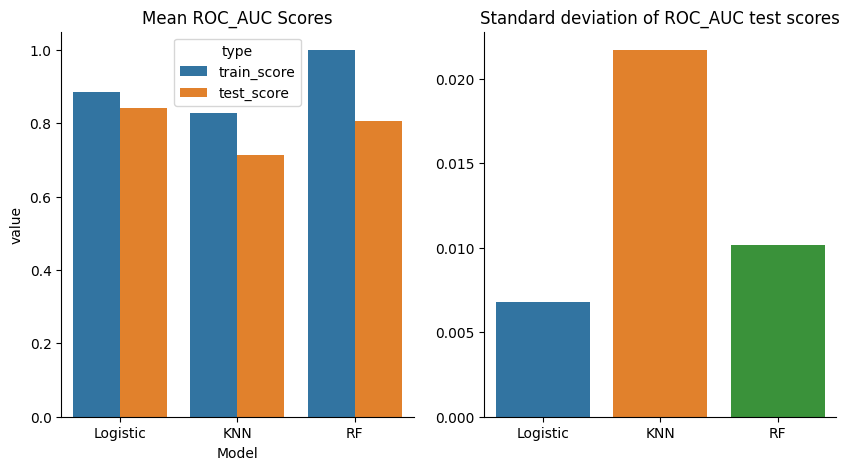

In [36]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
sns.barplot(data = score_df,
            x = 'Model',
            y = 'value',
            hue = 'type',
            ax = ax[0])
ax[0].set_title('Mean ROC_AUC Scores')

sns.barplot(x = names,
            y = std_scores,
            ax = ax[1])
ax[1].set_title('Standard deviation of ROC_AUC test scores')
sns.despine()

**Nhận xét**:
- Test score của mô hình phân loại Logistic là lớn nhất, độ lệch chuẩn giữa các lần test cũng thấp nhất
- Sự khác biệt giữa train score và test score của mô hình Random Forest là lớn nhất, có thể thấy được hiện tượng quá khớp (overfit) rõ ràng

#### So sánh đường cong ROC

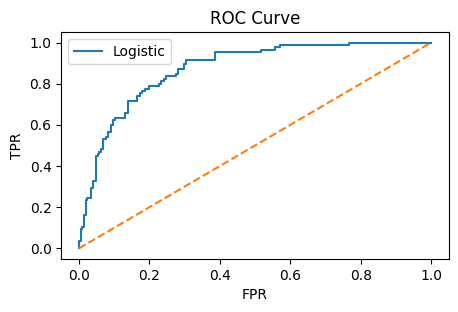

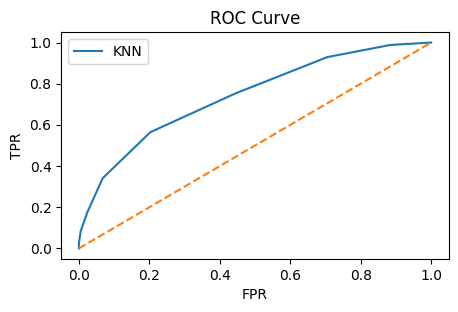

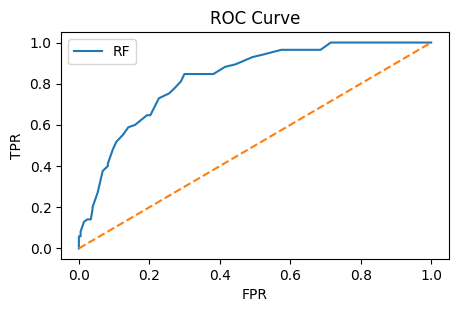

In [37]:
# Thử nghiệm trên 1 bộ dữ liệu phân chia bất kỳ
y_encoded = [1 if label =='Yes' else 0 for label in y]
X_tr, X_te, y_tr, y_te = train_test_split(X,y_encoded, test_size=0.3,random_state=40)
i = 1
for name, model in regressors:
    plt.figure(figsize=(5,10))
    plt.subplot(3,1,i)
    i+=1
    m = model.fit(X_tr, y_tr)
    y_prob = m.predict_proba(X_te)[:,1]
    fpr, tpr, threshholds = roc_curve(y_te, y_prob)
    plt.plot(fpr, tpr, label=name)
    plt.plot([0,1],[0,1],linestyle='--')
    plt.title('ROC Curve')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.legend()

**Nhận xét**:
- Mô hình Logistic có độ ổn định tốt và điểm trung bình ROC_AUC cao nhất, vậy có thể tái sử dụng mô hình Logistic trong tương lai để thực hiện dự đoán tình hình quá hạn nợ cho từng khách hàng với các đặc điểm cụ thể

#### So sánh confusion matrix

In [38]:
def drawConfusionMatrix(y_test,y_pred,title):
  cm = confusion_matrix(y_test, y_pred)
  # Create a heatmap for the confusion matrix
  plt.figure(figsize=(5, 3))
  sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=False)
  plt.xlabel('Predicted labels')
  plt.ylabel('True labels')
  plt.title(f'{title} confusion matrix')
  plt.show()

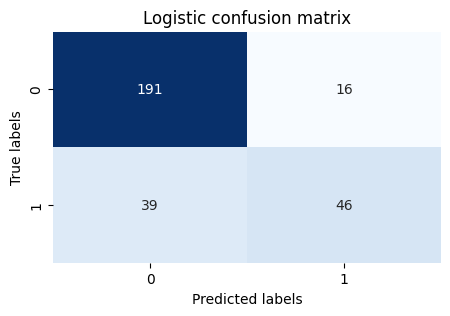

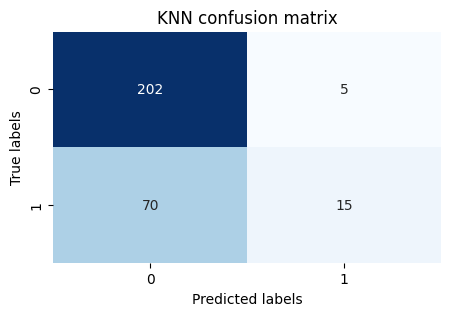

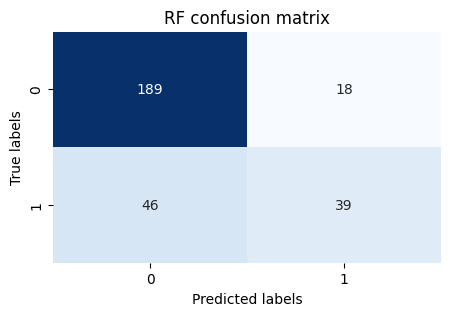

In [39]:
# Thử nghiệm trên 1 bộ dữ liệu phân chia bất kỳ
y_encoded = [1 if label =='Yes' else 0 for label in y]
X_tr, X_te, y_tr, y_te = train_test_split(X,y_encoded, test_size=0.3,random_state=40)
for name, model in regressors:
    m = model.fit(X_tr, y_tr)
    y_pred = m.predict(X_te)
    drawConfusionMatrix(y_te, y_pred, name)

# 7. Lưu lại mô hình tốt nhất

In [40]:
pd.DataFrame(cv_results[0])

,fit_time,score_time,estimator,test_score,train_score
0,0.376805,0.011968,"GridSearchCV(cv=StratifiedKFold(n_splits=3, ra...",0.833410,0.885176
1,0.386760,0.010971,"GridSearchCV(cv=StratifiedKFold(n_splits=3, ra...",0.850093,0.881274
2,0.382852,0.010970,"GridSearchCV(cv=StratifiedKFold(n_splits=3, ra...",0.841166,0.887037


Lấy ra kết quả có test_score roc_auc cao nhất

In [41]:
best_result = cv_results[0]['estimator'][1]
best_result

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=0, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num_pre',
                                                                         Pipeline(steps=[('Scaler',
                                                                                          StandardScaler())]),
                                                                         Index(['Sales Amount'], dtype='object')),
                                                                        ('cat_pre',
                                                                         Pipeline(steps=[('Encoder',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        sparse_output=False))]),
                                                                         Index(['Customer Gender', 'Customer City', 'Sales Employee', 'Sales Channel',
       'Ad Media', 'Product ID', 'Gen', 'Quarter'],
      dtype='object'))])),
                                       ('estimator', LogisticRegression())]),
             n_jobs=-1, param_grid={'estimator__C': [0.01, 0.1, 1.0]},
             scoring='roc_auc')

Lấy ra mô hình tốt nhất

In [42]:
best_result.best_estimator_

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num_pre',
                                                  Pipeline(steps=[('Scaler',
                                                                   StandardScaler())]),
                                                  Index(['Sales Amount'], dtype='object')),
                                                 ('cat_pre',
                                                  Pipeline(steps=[('Encoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse_output=False))]),
                                                  Index(['Customer Gender', 'Customer City', 'Sales Employee', 'Sales Channel',
       'Ad Media', 'Product ID', 'Gen', 'Quarter'],
      dtype='object'))])),
                ('estimator', LogisticRegression())])

Bộ siêu tham số tốt nhất

In [43]:
best_result.best_params_ 

{'estimator__C': 1.0}

Các đầu vào của thuật toán để ra được mô hình cùng với hệ số tương ứng

In [44]:
features = best_result.best_estimator_['preprocessor'].get_feature_names_out()
coefs = best_result.best_estimator_['estimator'].coef_[0]
pd.DataFrame({'Variable':features,
             'Coefficient':coefs})

,Variable,Coefficient
0,num_pre__Sales Amount,-0.532007
1,cat_pre__Customer Gender_Male,-0.442350
2,cat_pre__Customer City_C02,-0.400073
3,cat_pre__Customer City_C03,-1.035748
4,cat_pre__Sales Employee_E02,0.922946
5,cat_pre__Sales Employee_E03,1.073280
6,cat_pre__Sales Employee_E04,2.517831
7,cat_pre__Sales Employee_E05,-0.225281
8,cat_pre__Sales Employee_E06,-1.860413
9,cat_pre__Sales Employee_E07,0.307393


Lưu lại mô hình tốt nhất thành file để có thể tái sử dụng

In [45]:
import joblib
file = "classifer_logistic_model.pkl"
model = cv_results[0]['estimator'][2].best_estimator_
joblib.dump(model, file)

['classifer_logistic_model.pkl']

# 8. Kết luận

Qua bài phân tích trên, có thể thấy rằng các thuật toán phân loại trong học máy dự đoán dự đoán tương đối tốt doanh thu. Mô hình Logistic có thể được sử dụng để giải quyết được mục tiêu đề ra ban đầu để dự đoán khả năng xảy ra tình trạng nợ quá hạn đối với từng khách hàng cụ thể

**Đề xuất**:

    - Thực hiện thêm 1 số thuật toán học máy khác để đánh giá khả năng giải quyết vấn đề
    - Thu thập thêm dữ liệu để có khả năng các mô hình sẽ thể hiện tốt hơn 